In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/computer_vision/

/content/drive/MyDrive/computer_vision


In [4]:
ls

circ_test_pkl      fgdata_train_pkl      segmented_model_pkl
circ_train_pkl     fg_extraction_model/  semt_test_pkl
class_circ_model/  raw_test_pkl          semt_train_pkl
CV_Asg3.ipynb      raw_train_pkl         train-images-idx3-ubyte.gz
data/              segement_model/
fgdata_test_pkl    segmented_model/


In [5]:
import pickle
import cv2
import copy
import numpy as np
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt  

In [5]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [6]:
print(len(mnist_trainset))
print(len(mnist_testset))

60000
10000


In [7]:
train_len = len(mnist_trainset)
test_len = len(mnist_testset)
raw_train = []
raw_test = []
print(train_len)
print(test_len)
for i in range(train_len):
    # print(mnist_trainset[i])
    raw_train.append([np.array(mnist_trainset[i][0]),mnist_trainset[i][1]])
 
for i in range(test_len):
    raw_test.append([np.array(mnist_testset[i][0]),mnist_testset[i][1]])
 
raw_train_file = open('raw_train_pkl', 'wb')
pickle.dump(raw_train, raw_train_file)                     
raw_train_file.close()

raw_test_file = open('raw_test_pkl', 'wb')
pickle.dump(raw_test, raw_test_file)                     
raw_test_file.close()

60000
10000


# Q1 

## part 1


In [ ]:
def get_fg(dataset):
    data = []
    n = len(dataset)
    for i in range(n):
        timage = dataset[i][0]
        label = dataset[i][1]
        th_value,th_image = cv2.threshold(timage,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        data.append([timage,th_image,th_value,label])
    return data

train_fg = get_fg(raw_train)
test_fg = get_fg(raw_test)
print(train_fg[0][0].shape)

(28, 28)


In [ ]:
fgdata_train_file = open('fgdata_train_pkl', 'wb')
pickle.dump(train_fg, fgdata_train_file)                     
fgdata_train_file.close()

fgdata_test_file = open('fgdata_test_pkl', 'wb')
pickle.dump(test_fg, fgdata_test_file)                     
fgdata_test_file.close()

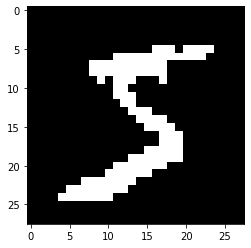

In [ ]:
plt.imshow(th_image,cmap="gray")
plt.show()
# plt.imshow(raw_train[0][0],cmap="gray")
# plt.show()


## part 2


In [ ]:
!pip install miniball

  Created wheel for miniball: filename=miniball-1.1.0-cp37-none-any.whl size=5297 sha256=b9d193bf01b32a4d192d54a0c21aa8fac2c29643b12c5c6d1907cb5995bca7fe
  Stored in directory: /root/.cache/pip/wheels/d2/c5/73/ec6902eb768c3ec6203eeb254703973987ff8c7099ffe5a903
Successfully built miniball


In [ ]:
import miniball


In [ ]:
def get_cirl(dataset):
    data = []
    n = len(dataset)
    for i in range(n):
        print(i)
        image = dataset[i][0]
        fg_image = copy.deepcopy(dataset[i][1])
        label = dataset[i][3]
        mask = np.array(np.where(fg_image == 255))
        C,r = miniball.get_bounding_ball(mask.transpose())
        c = (math.floor(C[1]), math.floor(C[0]))
        # cy = C[1]
        r = math.ceil(np.sqrt(r))
        circ_image = cv2.circle(fg_image, c, r, 255, thickness=1, lineType=8, shift=0)
        data.append([image, circ_image, dataset[i][1], label, c[1], c[0], r])
        # plt.imshow(circ_image,cmap="gray")
        # plt.show()
        # plt.imshow(dataset[i][1],cmap="gray")
        # plt.show()
    return data

train_circ = get_cirl(train_fg)
test_circ = get_cirl(test_fg)

circ_train_file = open('circ_train_pkl', 'wb')
pickle.dump(train_circ, circ_train_file)                     
circ_train_file.close()

circ_test_file = open('circ_test_pkl', 'wb')
pickle.dump(test_circ, circ_test_file)                     
circ_test_file.close()

In [ ]:
circ_train_file = open('circ_train_pkl', 'wb')
pickle.dump(train_circ, circ_train_file)                     
circ_train_file.close()

circ_test_file = open('circ_test_pkl', 'wb')
pickle.dump(test_circ, circ_test_file)                     
circ_test_file.close()

## Part 3

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
def get_semt(dataset):
    data = []
    n = len(dataset)
    for i in range(0,n,4):
        image1 = dataset[i][0]
        image2 = dataset[i+1][0]
        image3 = dataset[i+2][0]
        image4 = dataset[i+3][0]
        # print(type(image1))
        cmb_image = np.vstack([np.hstack([image1, image2]), np.hstack([image3, image4])])
        # print(cmb_image.shape)
        # plt.imshow(cmb_image,cmap="gray")
        # plt.show()
        row,col = cmb_image.shape
        
        label1 = dataset[i][3]
        label2 = dataset[i+1][3]
        label3 = dataset[i+2][3]
        label4 = dataset[i+3][3]
        # print(label1,label2,label3)
 
        mask1_pnts = np.array(np.where(dataset[i][1] == 255))
        mask2_pnts = np.array(np.where(dataset[i+1][1] == 255))
        mask2_pnts[1] = mask2_pnts[1]+28
        mask3_pnts = np.array(np.where(dataset[i+2][1] == 255))
        mask3_pnts[0] = mask3_pnts[0]+28
        mask4_pnts = np.array(np.where(dataset[i+3][1] == 255))
        mask4_pnts[0] = mask4_pnts[0]+28
        mask4_pnts[1] = mask4_pnts[1]+28 
 
        bg_mask1_pnts = np.array(np.where(dataset[i][1] == 0))
        bg_mask2_pnts = np.array(np.where(dataset[i+1][1] == 0))
        bg_mask2_pnts[1] = bg_mask2_pnts[1]+28
        bg_mask3_pnts = np.array(np.where(dataset[i+2][1] == 0))
        bg_mask3_pnts[0] = bg_mask3_pnts[0]+28
        bg_mask4_pnts = np.array(np.where(dataset[i+3][1] == 0))
        bg_mask4_pnts[0] = bg_mask4_pnts[0]+28
        bg_mask4_pnts[1] = bg_mask4_pnts[1]+28
 
        grnd_truth = np.zeros((row,col,11))
        grnd_truth[mask1_pnts[0],mask1_pnts[1],label1] = 1
        grnd_truth[mask2_pnts[0],mask2_pnts[1],label2] = 1
        grnd_truth[mask3_pnts[0],mask3_pnts[1],label3] = 1
        grnd_truth[mask4_pnts[0],mask4_pnts[1],label4] = 1
 
        grnd_truth[bg_mask1_pnts[0],bg_mask1_pnts[1],10] = 1
        grnd_truth[bg_mask2_pnts[0],bg_mask2_pnts[1],10] = 1
        grnd_truth[bg_mask3_pnts[0],bg_mask3_pnts[1],10] = 1
        grnd_truth[bg_mask4_pnts[0],bg_mask4_pnts[1],10] = 1
 
    
 
 
        # print(grnd_truth[:,:,label1])
        # plt.imshow(grnd_truth[:,:,label1],cmap="gray")
        # plt.show()
 
        # plt.imshow(grnd_truth[:,:,label2],cmap="gray")
        # plt.show()
        # plt.imshow(grnd_truth[:,:,label3],cmap="gray")
        # plt.show()
        # plt.imshow(grnd_truth[:,:,label4],cmap="gray")
        # plt.show()
 
        # plt.imshow(grnd_truth[:,:,10],cmap="gray")
        # plt.show()
 
        # plt.imshow(grnd_truth)
        # plt.show()
 
        # return
        print(i)
        data.append([cmb_image, grnd_truth])
    return data
 
    
 
train_semt = get_semt(train_fg)[:5000]
test_semt = get_semt(test_fg)

In [ ]:
semt_train_file = open('semt_train_pkl', 'wb')
pickle.dump(train_semt, semt_train_file)                     
semt_train_file.close()

semt_test_file = open('semt_test_pkl', 'wb')
pickle.dump(test_semt, semt_test_file)                     
semt_test_file.close()

# Q2

In [6]:
fgdata_train_file = open('fgdata_train_pkl', 'rb')
fgdata_test_file = open('fgdata_test_pkl', 'rb')
train_fgdata = pickle.load(fgdata_train_file)
test_fgdata = pickle.load(fgdata_test_file)

fgdata_train_file.close()
fgdata_test_file.close()

In [7]:
print(len(train_fgdata))
print(len(test_fgdata))

60000
10000


In [8]:
def get_fgdata_x_y(dataset):
    x = []
    y = []

    n = len(dataset)
    for i in range(n):
        # print(i)
        x.append(dataset[i][0].reshape((28,28,1)).astype(np.float32))
        y.append((dataset[i][1].reshape((28,28,1))/255).astype(np.float32))
    
    x = np.array(x)
    y = np.array(y)
    print(x.shape)
    print(y.shape)

    return x,y


train_fgdata_x, train_fgdata_y = get_fgdata_x_y(train_fgdata[:30000])
test_fgdata_x, test_fgdata_y = get_fgdata_x_y(test_fgdata)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
tf.keras.backend.clear_session()

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=train_fgdata_x.shape[1:], padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(layers.UpSampling2D(size=(2, 2)))
# model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=train_fgdata_y.shape[-1], kernel_size=(3, 3), activation='sigmoid', padding='same'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 32)        0

In [ ]:
# loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

In [ ]:
history = model.fit(train_fgdata_x, train_fgdata_y, epochs=10, batch_size=128,
                    validation_data=(test_fgdata_x, test_fgdata_y))

Epoch 1/10
235/235 [==============================] - 177s 747ms/step - loss: 0.1279 - binary_accuracy: 0.9522 - recall_1: 0.8309 - precision_1: 0.8384 - val_loss: 0.0207 - val_binary_accuracy: 0.9913 - val_recall_1: 0.9679 - val_precision_1: 0.9701
Epoch 2/10
235/235 [==============================] - 176s 750ms/step - loss: 0.0194 - binary_accuracy: 0.9919 - recall_1: 0.9722 - precision_1: 0.9692 - val_loss: 0.0157 - val_binary_accuracy: 0.9934 - val_recall_1: 0.9791 - val_precision_1: 0.9741
Epoch 3/10
235/235 [==============================] - 176s 750ms/step - loss: 0.0154 - binary_accuracy: 0.9936 - recall_1: 0.9781 - precision_1: 0.9757 - val_loss: 0.0168 - val_binary_accuracy: 0.9928 - val_recall_1: 0.9925 - val_precision_1: 0.9576
Epoch 4/10
235/235 [==============================] - 176s 749ms/step - loss: 0.0132 - binary_accuracy: 0.9945 - recall_1: 0.9813 - precision_1: 0.9788 - val_loss: 0.0118 - val_binary_accuracy: 0.9950 - val_recall_1: 0.9857 - val_precision_1: 0.9789


In [ ]:
model.save("fg_extraction_model") 

INFO:tensorflow:Assets written to: fg_extraction_model/assets


In [11]:
from tensorflow.keras.models import load_model

model = load_model("fg_extraction_model")

In [12]:
test_output_fgdata = model.predict(test_fgdata_x)
print(test_output_fgdata.shape)

(10000, 28, 28, 1)


In [15]:
def apply_thresh(dataset,th):
    data = []
    n = len(dataset)
    for i in range(n):
        dataset[i][dataset[i] >th] = 1
        dataset[i] = dataset[i].astype(np.uint8)
        # segment_image = np.zeros((m,n,3))
        # for j in range(num_class):
        #     segment_image[dataset[i][:,:,j]>th] = dic[j]
            # segment_image[dataset[i][:,:,j]<=th] = dic[10]
        # data.append(segment_image.astype(np.uint8))
    
    # return data

apply_thresh(test_output_fgdata,0.5)


In [16]:
from sklearn.metrics import jaccard_score
n_test = len(test_output_fgdata)
jc_score1 = 0
for i,j in zip(test_fgdata_y,test_output_fgdata):
    jc_score1+= jaccard_score(i.flatten(),j.flatten())

jc_score1 /= n_test 
print(jc_score1)

0.9791993266491706


In [ ]:
print(test_output_fgdata[0])

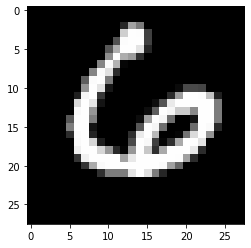

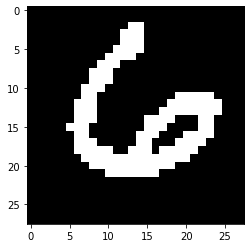

In [18]:

plt.imshow(test_fgdata_x[201].reshape((28,28)), cmap = "gray")
plt.show()


plt.imshow(test_output_fgdata[201].reshape((28,28)), cmap = "gray")
plt.show()


# Q3

In [18]:
circ_train_file = open('circ_train_pkl', 'rb')
circ_test_file = open('circ_test_pkl', 'rb')
train_circ = pickle.load(circ_train_file)
test_circ = pickle.load(circ_test_file)

circ_train_file.close()
circ_test_file.close()

In [19]:
print(len(train_circ))
print(len(test_circ))

60000
10000


In [20]:
def get_circ_x_y(dataset):
    x = []
    y = []
    b = []
    # [image, circ_image, dataset[i][1], label, c[1], c[0], r]
    n = len(dataset)
    for i in range(n):
        # print(i)
        x.append(dataset[i][0].reshape((28,28,1)))
        y.append(dataset[i][3])
        b.append([dataset[i][4]/28,dataset[i][5]/28,dataset[i][6]/28])
    

    x = np.array(x)
    y = np.array(y)
    b = np.array(b)
    print(x.shape)
    print(y.shape)
    print(b.shape)

    return x,{'label':y,'bbox':b}


train_circ_x, train_circ_y = get_circ_x_y(train_circ[:30000])
test_circ_x, test_circ_y  = get_circ_x_y(test_circ)

(30000, 28, 28, 1)
(30000,)
(30000, 3)
(10000, 28, 28, 1)
(10000,)
(10000, 3)


In [21]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

tf.keras.backend.clear_session()


In [22]:
def get_model():
    inputs = Input(shape=(28,28,1))
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu',padding="same")(inputs)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = GlobalAveragePooling2D()(x)

    classifier_head = Dropout(0.3)(x)
    classifier_head = Dense(10, activation='softmax', name='label')(classifier_head)

    reg_head = Dense(64, activation='relu')(x)
    reg_head = Dense(32, activation='relu')(reg_head)
    reg_head = Dense(3, activation='sigmoid', name='bbox')(reg_head)

    return Model(inputs=[inputs], outputs=[classifier_head, reg_head])

In [23]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [28]:
losses = {'label': 'sparse_categorical_crossentropy',
          'bbox': 'mse'}

loss_weights = {'label': 1.0,
                'bbox': 1.0}

In [29]:
model.compile('adam', loss=losses, loss_weights=loss_weights, metrics=['acc'])

In [30]:
history = model.fit(train_circ_x, train_circ_y, epochs=20, batch_size=32,
                    validation_data=(test_circ_x, test_circ_y))

Epoch 1/20
938/938 [==============================] - 6s 6ms/step - loss: 1.5694 - label_loss: 1.5634 - bbox_loss: 0.0060 - label_acc: 0.5054 - bbox_acc: 0.5909 - val_loss: 0.1215 - val_label_loss: 0.1205 - val_bbox_loss: 0.0010 - val_label_acc: 0.9661 - val_bbox_acc: 0.6695
Epoch 2/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1984 - label_loss: 0.1975 - bbox_loss: 9.6111e-04 - label_acc: 0.9406 - bbox_acc: 0.7359 - val_loss: 0.0722 - val_label_loss: 0.0714 - val_bbox_loss: 8.1979e-04 - val_label_acc: 0.9783 - val_bbox_acc: 0.7731
Epoch 3/20
938/938 [==============================] - 5s 6ms/step - loss: 0.1311 - label_loss: 0.1303 - bbox_loss: 7.9853e-04 - label_acc: 0.9606 - bbox_acc: 0.7537 - val_loss: 0.0603 - val_label_loss: 0.0595 - val_bbox_loss: 7.7881e-04 - val_label_acc: 0.9815 - val_bbox_acc: 0.7480
Epoch 4/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0990 - label_loss: 0.0983 - bbox_loss: 7.5067e-04 - label_acc: 0.9695 - bbox_acc

In [ ]:
model.save("class_circ_model") 

INFO:tensorflow:Assets written to: class_circ_model/assets


In [22]:
from tensorflow.keras.models import load_model
model = load_model("class_circ_model")

In [31]:
test_output_circ = model.predict(test_circ_x)
print(len(test_output_circ))

2


In [32]:
print((test_output_circ[0].shape))
print((test_output_circ[1].shape))

(10000, 10)
(10000, 3)


In [41]:
def get_label_circ(output):
    output_labels = output[0]
    output_circ = output[1]
    labels = np.argmax(output_labels, axis=1)
    print(labels.shape)
    output_circ = (output_circ*28).astype(np.uint8)

    # output_circ[:,0:2] = np.floor(output_circ[:,0:2])
    # output_circ[:,2] = np.ceil(output_circ[:,2])

    return labels, output_circ

pred_label, pred_circ = get_label_circ(test_output_circ)

(10000,)


In [42]:
print(test_circ_y)

{'label': array([7, 2, 1, ..., 4, 5, 6]), 'bbox': array([[0.53571429, 0.42857143, 0.39285714],
       [0.42857143, 0.57142857, 0.42857143],
       [0.46428571, 0.5       , 0.39285714],
       ...,
       [0.53571429, 0.57142857, 0.39285714],
       [0.53571429, 0.60714286, 0.39285714],
       [0.39285714, 0.46428571, 0.42857143]])}


In [43]:
print(pred_label)
print(pred_circ)

[7 2 1 ... 4 5 6]
[[15 12 11]
 [12 14 11]
 [13 13 10]
 ...
 [15 15 10]
 [13 15 11]
 [10 13 11]]


In [44]:
def get_circ_ext(dataset):
    mask = []
    enc = []
    y = []
    # [image, circ_image, dataset[i][1], label, c[1], c[0], r]
    n = len(dataset)
    for i in range(n):
        # print(i)
        mask.append(dataset[i][2])
        enc.append(dataset[i][1])
        y.append(dataset[i][3])

    mask = np.array(mask)
    enc = np.array(enc)
    y = np.array(y)
    print(mask.shape)
    print(enc.shape)
    print(y.shape)

    return mask, enc, y

test_circ_mask, test_circ_enc, test_circ_label  = get_circ_ext(test_circ)

(10000, 28, 28)
(10000, 28, 28)
(10000,)


In [45]:
def do_enc(mask, circ):
    data = []
    n = len(mask)
    for i in range(n):
        circ_image = cv2.circle(mask[i], (circ[i][1],circ[i][0]), circ[i][2], 255, thickness=1, lineType=8, shift=0)
        data.append(circ_image)
    
    return data

pred_enc_circ = do_enc(test_circ_mask, pred_circ)

In [48]:
from sklearn.metrics import jaccard_score

class Point:
	def __init__(self,x,y):
		self.x = x
		self.y = y

class Circle:
	def __init__(self,c,r):
		self.c = c
		self.r = r

def dist(a,b):
	return np.sqrt((a.x -b.x)**2 + (a.y-b.y)**2)

def inside(c,p):
	if(dist(c.c,p)<=c.r):
		return True
	return False

def compute_jc_score2(test_circ_y, pred_label, pred_circ):
    n_test = len(test_circ_y)
    # test_circ_y = test_circ_y.astype(np.uint8)
    jc_score = 0
    true_label = test_circ_y['label']
    true_circ = (test_circ_y['bbox']*28).astype(np.uint8)
    for i in range(n_test):
        if(true_label[i]!=pred_label[i]):
            continue
        true_mask = np.zeros((28,28))
        pred_mask = np.zeros((28,28))
        tc = Circle(Point(true_circ[i][1],true_circ[i][0]),true_circ[i][2])
        pc = Circle(Point(pred_circ[i][1],pred_circ[i][0]),pred_circ[i][2]) 
        for j in range(28):
            for k in range(28):
                p = Point(j,k)
                if(inside(tc,p)):
                    true_mask[j][k] = 1
                if(inside(pc,p)):
                    pred_mask[j][k] = 1
        jc_score+= jaccard_score(true_mask.flatten(),pred_mask.flatten())
    
    return jc_score/n_test

jc_score2 = compute_jc_score2(test_circ_y, pred_label, pred_circ)
print(jc_score2)

0.8899782135076253


circle information
[15. 12. 11.]
[15 12 11]


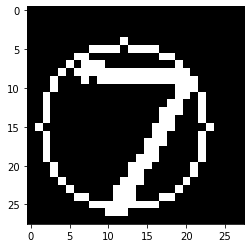

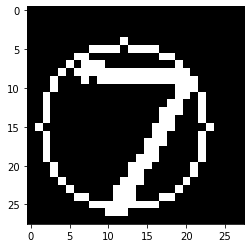

In [49]:
sample = 0
print("circle information")
print(test_circ_y['bbox'][sample]*28)
print(pred_circ[sample])

plt.imshow(test_circ_enc[sample],cmap = "gray")
plt.show()
plt.imshow(pred_enc_circ[sample],cmap = "gray")
plt.show()

In [40]:
 from sklearn.metrics import accuracy_score
 print("Test Accuracy score: ", accuracy_score(test_circ_label, pred_label))

Test Accuracy score:  0.9863


# Q4

In [6]:
semt_train_file = open('semt_train_pkl', 'rb')
semt_test_file = open('semt_test_pkl', 'rb')
train_semt = pickle.load(semt_train_file)
test_semt = pickle.load(semt_test_file)

semt_train_file.close()
semt_test_file.close()

In [7]:
print(len(train_semt))
print(len(test_semt))

5000
2500


In [8]:
def get_semt_x_y(dataset):
    x = []
    y = []

    n = len(dataset)
    for i in range(n):
        # print(i)
        x.append(dataset[i][0].reshape((56,56,1)))
        y.append(dataset[i][1])
    
    x = np.array(x)
    y = np.array(y)
    print(x.shape)
    print(y.shape)

    return x,y


train_semt_x, train_semt_y = get_semt_x_y(train_semt)
test_semt_x, test_semt_y = get_semt_x_y(test_semt)

(5000, 56, 56, 1)
(5000, 56, 56, 11)
(2500, 56, 56, 1)
(2500, 56, 56, 11)


In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
tf.keras.backend.clear_session()


In [10]:
model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=train_semt_x.shape[1:], padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=train_semt_y.shape[-1], kernel_size=(3, 3), activation='sigmoid', padding='same'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

In [13]:
history = model.fit(train_semt_x, train_semt_y, epochs=15, batch_size=32,
                    validation_data=(test_semt_x, test_semt_y))

Epoch 1/15
157/157 [==============================] - 35s 23ms/step - loss: 0.1311 - binary_accuracy: 0.9534 - recall: 0.7722 - precision: 0.7670 - val_loss: 0.0486 - val_binary_accuracy: 0.9842 - val_recall: 0.8360 - val_precision: 0.9881
Epoch 2/15
157/157 [==============================] - 3s 17ms/step - loss: 0.0449 - binary_accuracy: 0.9850 - recall: 0.8495 - precision: 0.9830 - val_loss: 0.0363 - val_binary_accuracy: 0.9865 - val_recall: 0.8686 - val_precision: 0.9806
Epoch 3/15
157/157 [==============================] - 3s 17ms/step - loss: 0.0343 - binary_accuracy: 0.9873 - recall: 0.8854 - precision: 0.9729 - val_loss: 0.0260 - val_binary_accuracy: 0.9901 - val_recall: 0.9217 - val_precision: 0.9681
Epoch 4/15
157/157 [==============================] - 3s 17ms/step - loss: 0.0257 - binary_accuracy: 0.9903 - recall: 0.9253 - precision: 0.9669 - val_loss: 0.0212 - val_binary_accuracy: 0.9919 - val_recall: 0.9405 - val_precision: 0.9698
Epoch 5/15
157/157 [=======================

In [ ]:
model.save("segmented_model") 

INFO:tensorflow:Assets written to: segmented_model/assets


In [9]:
from tensorflow.keras.models import load_model

model = load_model("segmented_model")

In [14]:
test_output_semt = model.predict(test_semt_x)
print(test_output_semt.shape)

(2500, 56, 56, 11)


In [17]:
from sklearn.metrics import jaccard_score

n_test = len(test_output_semt)
jc_score3 = 0
test_output_copy = copy.deepcopy(test_output_semt)
test_output_copy[test_output_copy >= 0.5] = 1
test_output_copy[test_output_copy < 0.5] = 0
test_output_copy = test_output_copy.astype(np.uint8)
for i,k in zip(test_semt_y,test_output_copy):
    jc_score3 += jaccard_score(i.flatten(),k.flatten())

jc_score3/=n_test
print(jc_score3)

0.9604184124533751


In [41]:
from sklearn.metrics import jaccard_score

n_test = len(test_output_semt)
jc_score3 = 0
for i,k in zip(test_semt_y,test_output_semt):
    n_layer = i.shape[-1]
    l_jc_score = 0
    j =  copy.deepcopy(k)
    j[j > 0.5] = 1
    j[j<=0.5] = 0
    for l in range(n_layer):
        l_jc_score += jaccard_score(i[:,:,l].flatten(),j[:,:,l].flatten())
    jc_score3+= (l_jc_score/n_layer)


jc_score3 /= n_test 
print(jc_score3)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.343130343870159


In [ ]:
def draw_image(dataset,th):
    data = []
    n = len(dataset)
    dic = {0: [255,0,0], 1: [0,0,255], 2: [0,255,0], 3: [255,255,0], 4: [255,0,255], 5: [0,255,255], 6: [255,255,255], 7: [25,50,40], 8: [0,80,90], 9: [250,120,120], 10: [0,0,0] }

    for i in range(n):
        m,n,num_class = dataset[i].shape[:3]
        segment_image = np.zeros((m,n,3))
        for j in range(num_class):
            segment_image[dataset[i][:,:,j]>th] = dic[j]
            # segment_image[dataset[i][:,:,j]<=th] = dic[10]
        data.append(segment_image.astype(np.uint8))
    
    return data

final_semt_data = draw_image(test_output_semt,0.5)


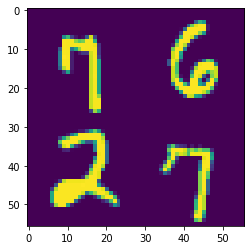

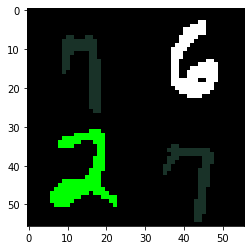

In [ ]:

plt.imshow(test_semt_x[20].reshape((56,56)))
plt.show()


plt.imshow(final_semt_data[20])
plt.show()
